Intention of this Notebook ist to improve the performance of a "default" CNN network. Hyperparameters are choosen based on the results of the cnn_regressor_hypertuning notebook results, i.e. the most promising hyperparameter changes combined and then another round of single hyperparameter changes evaluated.

Comparison:
  * Default model average performance: MAE: 6.251872683314947,  RMSE: 8.929572292868341
  * Default model second split of 3 fold inner split performance: MAE: 6.240022255288514, RMSE:  8.938713315589355.
  * Default model 95% confidence interval: MAE: (6.118740486386132, 6.3850055136138675), RMSE: (8.673900578108704, 9.185243421891297). If we see values lower then the lower bounds it may indicate significant improvement and justify further investigation. 

Comparison Hypertuning:

* i.	Label scaled (z-score) vs non scaled: RMSE:  8.832355718806802 
* iii.	Batch size 1024 vs 512: RMSE: 8.76508756699281 
* vii.	Global average vs global max pool:	RMSE:  8.874210860066288 
* viii.	2 vs 3 stages (stages divided by max pool): RMSE:  8.837730955639133  
* x.	128, 256 vs 256,512 filter counts per CNN stage: RMSE:  8.554933590354343 
* xi.	2 vs 3 fully connected layers: RMSE:  8.883239127232303
* xii.	ResNet type feed forward concatenation: RMSE:  8.796745531785053

## Set up notebook and environment: 

### Connect to google drive: ###

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras #where?
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.image as mpimg
from keras.utils import plot_model
from sklearn import preprocessing
import gc
from sklearn.model_selection import KFold

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Specify location of all relevant data: (YOU HAVE TO INSERT YOUR FILE LOCATIONS) ###

In [0]:
print("Check correctnes of locations: ")
data_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Data/"
model_saves_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/"
data_filter_location = data_folder_location+"merck_and_co_dup_aa_concat_filter.npy"
X_location = data_folder_location+"X.npy"
y_location = data_folder_location+"y_growth_avg.npy"
print(os.path.isdir(data_folder_location))
print(os.path.isdir(model_saves_folder_location))
print(os.path.isfile(data_filter_location))
print(os.path.isfile(X_location))
print(os.path.isfile(y_location))

Check correctnes of locations: 
True
True
True
True
True


### Function to easily retrieve cleaned data with split either from drive or cache, depending wheter data was already retrieved using this function ###

In [0]:
def retrieve_data(X_loc, y_loc, test_split=0.2, random_state=42):
  if not(os.path.isfile("X_train_H.npy")):
    #Load data from drive
    print("Loading data from drive...")
    X_load = np.load(X_loc)
    y_load = np.load(y_loc)
    filter_load = np.load(data_filter_location)
    
    #Apply pre filter
    X_load = X_load[filter_load]
    y_load = y_load[filter_load]
    gc.collect()
    
    #Remove all entries that have no temperature information #can happen, since for some organism specific temperature information is not available
    temp_label_filter = np.logical_not(np.isnan(y_load))
    X_load = X_load[temp_label_filter]
    y_load = y_load[temp_label_filter]
    gc.collect()
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_load, y_load, test_size=test_split, random_state=random_state) 
    
    #Cache data
    print("Caching data...")
    np.save('X_train_H.npy', X_train)   
    np.save('X_test_H.npy', X_test)   
    np.save('y_train_H.npy', y_train)   
    np.save('y_test_H.npy', y_test) 
    
    return X_train, X_test, y_train, y_test
  else:
    print("Loading data from cache...")
    return np.load('X_train_H.npy'), np.load('X_test_H.npy'), np.load('y_train_H.npy'), np.load('y_test_H.npy') 

In [0]:
X_train, X_test, y_train, y_test = retrieve_data(X_location,y_location)
gc.collect()

Loading data from drive...
Caching data...


10

### Create inner split filters

In [0]:
kf = KFold(n_splits=3, random_state=42375, shuffle=True)

In [0]:
k_splits = []
for train_index, test_index in kf.split(X_train):
  k_splits.append((train_index, test_index))

In [0]:
train_index_01, test_index_01 = k_splits[0]
train_index_02, test_index_02 = k_splits[1] #showd average performance
train_index_03, test_index_03 = k_splits[2]

In [0]:
train_index_01[:10] #just rough check that its the same data

array([ 0,  1,  2,  4,  5,  6,  9, 10, 11, 13])

### Create appropriate subset of data (filter, and scale)

Performance tests will only happen on the second split of the 3-fold split, due to low variance and resouce intensivenes of task. Tus data can be pre calculated for all data.

In [0]:
gc.collect()

130

In [0]:
X_train_inner, X_test_inner = X_train[train_index_02], X_train[test_index_02]
y_train_inner, y_test_inner = y_train[train_index_02], y_train[test_index_02]

In [0]:
standard_scaler_inner = preprocessing.StandardScaler()
y_train_scaled_inner = standard_scaler_inner.fit_transform(y_train_inner.reshape(-1, 1)).reshape((len(y_train_inner))) #only fit on y_train to prevent information leakage

#actually nonsensical, but in this case not a big problem, since its the tune set
standard_scaler_test_inner = preprocessing.StandardScaler()
y_test_scaled_inner = standard_scaler_test_inner.fit_transform(y_test_inner.reshape(-1, 1)).reshape((len(y_test_inner))) #scale y_test seperately

In [0]:
print(X_train_inner.shape)
print(y_train_scaled_inner.shape)
print(X_test_inner.shape)
print(y_test_scaled_inner.shape)

(4099573, 650)
(4099573,)
(2049786, 650)
(2049786,)


In [0]:
y_offset = len(y_test_inner)%8 #needed because of 8 tpu cores, only for validation?
print(y_offset)

2


In [0]:
del X_train
del X_test
del y_train
del y_test
gc.collect()

0

## Supplementary functions

In [0]:
def train_on_TPU_regression(model,model_save_loc, X_train, y_train, X_test, y_test, batch_size=1024, epochs=25, save_best_only=True, period=1, train_patience=3, mse=True, weight_loc=None):
  print("Batch size: {} (this corresponds to {} on GPUs)".format(batch_size,batch_size//8))
  print("Optimization criterion MSE: ", str(mse))
  print("Epochs: ", epochs)
  print("Patience: ", train_patience)
  print("Period: ", period)
  print("Save best only: ",save_best_only)
  print("Model save location: ",model_save_loc)
  print("\n")
  
  #Identify TPU worker
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  
  #Useful to avoid clutter from old models / layers.
  tf.keras.backend.clear_session()

  #Convert model to TPU model
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  print("\n")

  #Compile the model
  if mse:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss=tf.keras.losses.mean_squared_error,
      metrics=['mse']
    )
  else:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), 
      loss=tf.keras.losses.mean_absolute_error,
      metrics=['mae']
    )
    
  if not(weight_loc is None):
    tpu_model.load_weights(weight_loc)
  
  #Configure how to save model and early stopping
  callbacks_list = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath=model_save_loc,
          save_weights_only=True,
          monitor='val_loss', 
          save_best_only=save_best_only,
          mode='auto',
          period=period),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                       patience=train_patience, #more than 3 doesnt help (except when using generator), since the TPU runs out ouf memory for some reason???
                                       mode='auto')
  ]
  
  history = tpu_model.fit(X_train,
                          y_train,
                          validation_data=(X_test,y_test),
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=callbacks_list,
                          verbose=1)

  return tpu_model, history

In [0]:
def calc_reg_pred(model, weight_loc, X_test, y_test, batch_size=1024, mse=True, scaler=None):
  print("TPU worker setup:")
  #Identify TPU worker
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  
  #Useful to avoid clutter from old models / layers.
  tf.keras.backend.clear_session()
  
  #Convert model to TPU model
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  print("\n")
  
  #Compile the model #doesnt really matter which loss function here
  if mse:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), 
      loss=tf.keras.losses.mean_squared_error,
      metrics=['mse']
    )
  else:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss=tf.keras.losses.mean_absolute_error,
      metrics=['mae']
    )
  
  tpu_model.load_weights(weight_loc)
  
  print("Calculating predictions:")
  y_pred = tpu_model.predict(X_test, batch_size=1024, verbose=1)

  if not(scaler is None):
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
  rmse_err = np.sqrt(mean_squared_error(y_test, y_pred)) 
  mae_err = mean_absolute_error(y_test, y_pred)
  
  return y_pred, rmse_err, mae_err

In [0]:
def plt_model(model,figure_size=(25,25)):
  plt.figure(figsize=figure_size)
  plot_model(model, to_file='model.png')
  plt.imshow(mpimg.imread('model.png'))
  plt.show()

In [0]:
def plt_history(history):
  #history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Define, Train and Test Models 


In [0]:
SEQUENCE_LEN = 650
CLASSES = 21 #now that sequences with non cannonical AAs removed there are 20 left and "0" encoding "None"

### i.	Batch size 512, ResNet type, (256,512) filter counts per CNN stage //MAE: 5.89394053276791, RMSE: 8.639569394883397 //Somewhat worse than (256,512) filter counts per CNN stage on its own //Stopped to early, could retry with patience=5

In [0]:
#model name:
model_name = "i"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalAveragePooling1D()(x_mid)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_average_pooling1d[0][0]   
                                                                 global_average_pooling1d_1[0][0] 
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            513         activation_6[0][0]               
==================================================================================================
Total params: 2,781,609
Trainable params: 2,775,977
Non-trainable params: 5,632
__________________________________________________________________________________________________
```



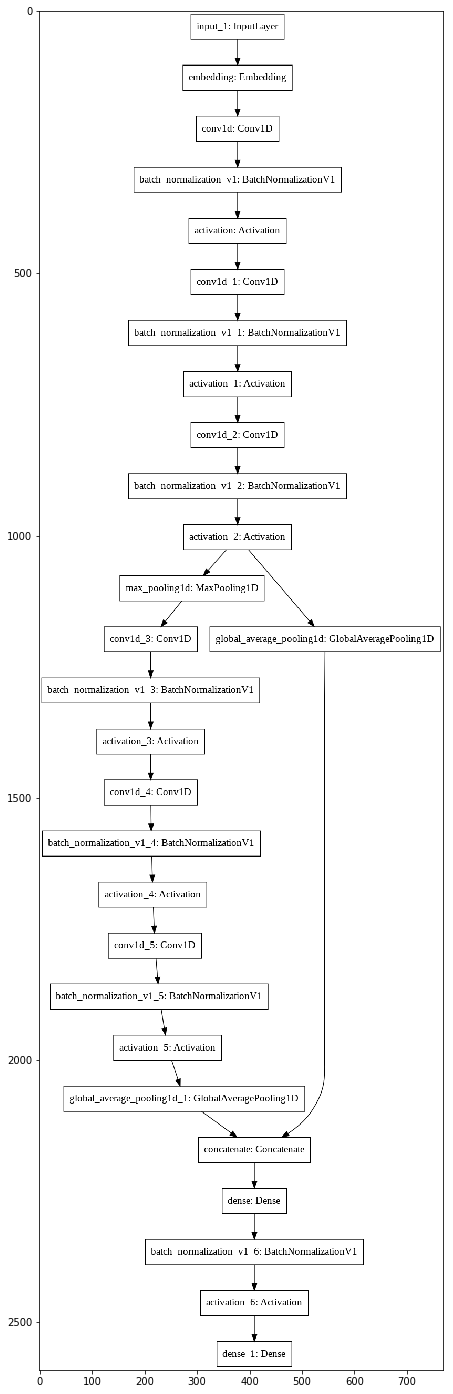

In [0]:
plt_model(model)

In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/model_hypertuning_advancedi.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.113.32.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2085274587762135440)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14132380918734491335)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1400207629764384067)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2610160740570331609)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12601441904887026250)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12245044461565163595)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 937115320268804004)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 15628920438446328280)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 11321445158460057905)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 338995971991697862)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 3708225360176882797)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.956686735153198 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6582 - mean_squared_error: 0.6582INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.215808153152466 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6582 - mean_squared_error: 0.6582INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.98595929145813 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.54425311088562 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 733s 179us/sample - loss: 0.6582 - mean_squared_error: 0.6582 - val_loss: 0.9660 - val_mean_squared_error: 0.9660
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5714 - mean_squared_error: 0.5714INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 697s 170us/sample - loss: 0.5714 - mean_squared_error: 0.5714 - val_loss: 0.5753 - val_mean_squared_error: 0.5753
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5214 - mean_squared_error: 0.5214INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 695s 170us/sample - loss: 0.5214 - mean_squared_error: 0.5214 - val_loss: 0.5452 - val_mean_squared_error: 0.5452
Epoch 4/25
4099573/4099573 [==============================] - 696s 170us/sample - loss: 0.4839 - mean_squared_error: 0.4839 - val_loss: 0.5873 - val_mean_squared_error: 0.5873
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4540 - mean_squared_error: 0.4540INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 698s 170us/sample - loss: 0.4540 - mean_squared_error: 0.4540 - val_loss: 0.5053 - val_mean_squared_error: 0.5053
Epoch 6/25
4099573/4099573 [==============================] - 693s 169us/sample - loss: 0.4282 - mean_squared_error: 0.4282 - val_loss: 0.6206 - val_mean_squared_error: 0.6206
Epoch 7/25
3484160/4099573 [========================>.....] - ETA: 1:34 - loss: 0.4051 - mean_squared_error: 0.4051Buffered data was truncated after reaching the output size limit.
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.89394053276791
Root mean squared error:  8.639569394883397
```



### ii. Model i with global max pool and 3 fully connected layers //MAE: 5.721332726293479, RMSE: 8.31834661119527 //Promising //Convergence until 3rd epoch with .5 scaled RMSE

In [0]:
#model name:
model_name = "ii"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         activation_7[0][0]               
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/model_hypertuning_advanced_ii.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.8.54.90:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 17872842443398638676)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13548695405083601962)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11006585510668196125)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12286585194538116613)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4766802579066811011)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 11794630411430587055)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 8602171284243117800)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 9316880218091937387)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 8945240803113963658)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 14435654154090402890)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 18162956789846452197)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.368588447570801 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6498 - mean_squared_error: 0.6498INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.560288429260254 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6498 - mean_squared_error: 0.6498INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.229100942611694 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.7970967292785645 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 777s 190us/sample - loss: 0.6498 - mean_squared_error: 0.6498 - val_loss: 0.6069 - val_mean_squared_error: 0.6069
Epoch 2/25
4099573/4099573 [==============================] - 719s 175us/sample - loss: 0.5543 - mean_squared_error: 0.5543 - val_loss: 0.6106 - val_mean_squared_error: 0.6106
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5038 - mean_squared_error: 0.5038INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 724s 177us/sample - loss: 0.5038 - mean_squared_error: 0.5038 - val_loss: 0.5098 - val_mean_squared_error: 0.5098
Epoch 4/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4652 - mean_squared_error: 0.4652INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 719s 175us/sample - loss: 0.4652 - mean_squared_error: 0.4652 - val_loss: 0.4915 - val_mean_squared_error: 0.4915
Epoch 5/25
4099573/4099573 [==============================] - 709s 173us/sample - loss: 0.4340 - mean_squared_error: 0.4340 - val_loss: 0.5056 - val_mean_squared_error: 0.5056
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4063 - mean_squared_error: 0.4063INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 707s 173us/sample - loss: 0.4063 - mean_squared_error: 0.4063 - val_loss: 0.4625 - val_mean_squared_error: 0.4625
Epoch 7/25
3476992/4099573 [========================>.....] - ETA: 1:37 - loss: 0.3816 - mean_squared_error: 0.3816Buffered data was truncated after reaching the output size limit.
```



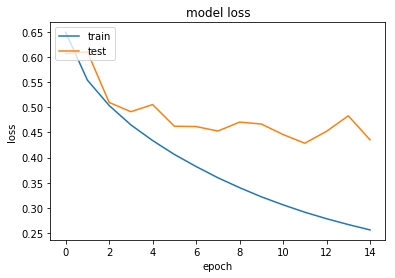

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.721332726293479
Root mean squared error:  8.31834661119527
```



### iii. Model ii without scaled label //MAE: 5.892277118022296, RMSE:  8.491438707784022 //Somewhat worse

In [0]:
#model name:
model_name = "iii"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         activation_7[0][0]               
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_inner, X_test_inner[:-y_offset], y_test_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/model_hypertuning_advanced_iii.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.8.54.90:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 17872842443398638676)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13548695405083601962)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11006585510668196125)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12286585194538116613)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4766802579066811011)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 11794630411430587055)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 8602171284243117800)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 9316880218091937387)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 8945240803113963658)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 14435654154090402890)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 18162956789846452197)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.270375728607178 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 111.1014 - mean_squared_error: 111.1016INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.102912425994873 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 111.0975 - mean_squared_error: 111.0978INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.422673463821411 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.003188610076904 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 786s 192us/sample - loss: 111.0961 - mean_squared_error: 111.0963 - val_loss: 103.8048 - val_mean_squared_error: 103.8048
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 89.1363 - mean_squared_error: 89.1362INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 732s 179us/sample - loss: 89.1368 - mean_squared_error: 89.1367 - val_loss: 89.2617 - val_mean_squared_error: 89.2616
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 81.4218 - mean_squared_error: 81.4218INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 731s 178us/sample - loss: 81.4215 - mean_squared_error: 81.4215 - val_loss: 83.8278 - val_mean_squared_error: 83.8279
Epoch 4/25
4099573/4099573 [==============================] - 727s 177us/sample - loss: 75.6077 - mean_squared_error: 75.6077 - val_loss: 89.2056 - val_mean_squared_error: 89.2054
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 70.7985 - mean_squared_error: 70.7984INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 727s 177us/sample - loss: 70.7987 - mean_squared_error: 70.7987 - val_loss: 81.4212 - val_mean_squared_error: 81.4212
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 66.3602 - mean_squared_error: 66.3602INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 728s 178us/sample - loss: 66.3588 - mean_squared_error: 66.3588 - val_loss: 75.9270 - val_mean_squared_error: 75.9271
Epoch 7/25
3266560/4099573 [======================>.......] - ETA: 2:14 - loss: 62.4001 - mean_squared_error: 62.4000Buffered data was truncated after reaching the output size limit.
```



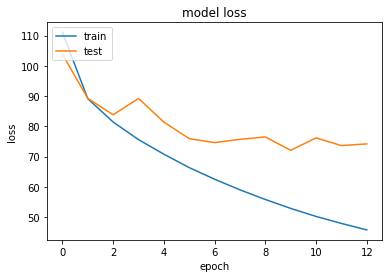

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset])

TPU worker setup:
INFO:tensorflow:Querying Tensorflow master (grpc://10.8.54.90:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 17872842443398638676)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13548695405083601962)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11006585510668196125)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12286585194538116613)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4766802579066811011)
INFO:tensorflow:*** Available Device: 

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)

Mean absolute error:  5.892277118022296
Root mean squared error:  8.491438707784022




```
Mean absolute error:  5.892277118022296
Root mean squared error:  8.491438707784022
```



### iv. Model ii with 3 stages //MAE: 5.984425172205987, RMSE:  8.59281117035633 //Somewhat worse

In [0]:
#model name:
model_name = "iv"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid_2 = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid_2)
x = tf.keras.layers.Conv1D(1024, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(1024, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(1024, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x_mid_2 = tf.keras.layers.GlobalMaxPooling1D()(x_mid_2)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x_mid_2, x], axis=-1)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 33, 512)      0           activation_5[0][0]               
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 31, 1024)     1573888     max_pooling1d_1[0][0]            
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 31, 1024)     4096        conv1d_6[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 31, 1024)     0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 29, 1024)     3146752     activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 29, 1024)     4096        conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 29, 1024)     0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 27, 1024)     3146752     activation_7[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_8 (Batch (None, 27, 1024)     4096        conv1d_8[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 27, 1024)     0           batch_normalization_v1_8[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 1024)         0           activation_8[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1792)         0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
                                                                 global_max_pooling1d_2[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         1836032     concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 1024)         4096        dense[0][0]                      
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 1024)         0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         1049600     activation_9[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_10 (Batc (None, 1024)         4096        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 1024)         0           batch_normalization_v1_10[0][0]  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            1025        activation_10[0][0]              
==================================================================================================
Total params: 13,159,849
Trainable params: 13,145,001
Non-trainable params: 14,848
__________________________________________________________________________________________________
```



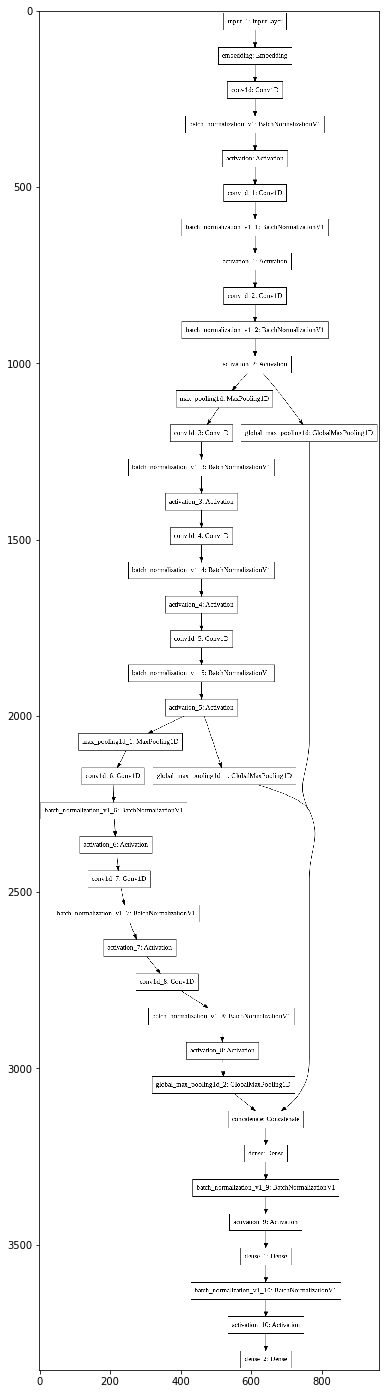

In [0]:
plt_model(model)

In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/model_hypertuning_advanced_iv.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.12.248.122:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4273206023553425208)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12385076021438912356)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11078345266942851960)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16144330192661547982)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4943037940559239881)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9038175605792892315)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 10234911853030510262)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 7946712602397252032)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 7132169946608433242)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 11884688357336035592)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 13588935507713946626)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 11.90364670753479 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6710 - mean_squared_error: 0.6710INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 10.574322700500488 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6710 - mean_squared_error: 0.6710INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.548882722854614 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.955761194229126 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 1043s 254us/sample - loss: 0.6710 - mean_squared_error: 0.6710 - val_loss: 0.6203 - val_mean_squared_error: 0.6203
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5653 - mean_squared_error: 0.5653INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 966s 236us/sample - loss: 0.5653 - mean_squared_error: 0.5653 - val_loss: 0.5466 - val_mean_squared_error: 0.5466
Epoch 3/25
4099573/4099573 [==============================] - 959s 234us/sample - loss: 0.5115 - mean_squared_error: 0.5115 - val_loss: 0.5816 - val_mean_squared_error: 0.5816
Epoch 4/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4719 - mean_squared_error: 0.4719INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 965s 235us/sample - loss: 0.4719 - mean_squared_error: 0.4719 - val_loss: 0.5221 - val_mean_squared_error: 0.5221
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4384 - mean_squared_error: 0.4384INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 954s 233us/sample - loss: 0.4384 - mean_squared_error: 0.4384 - val_loss: 0.4719 - val_mean_squared_error: 0.4719
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4092 - mean_squared_error: 0.4092INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 955s 233us/sample - loss: 0.4092 - mean_squared_error: 0.4092 - val_loss: 0.4581 - val_mean_squared_error: 0.4581
Epoch 7/25
3456512/4099573 [========================>.....] - ETA: 2:16 - loss: 0.3830 - mean_squared_error: 0.3830Buffered data was truncated after reaching the output size limit.
```



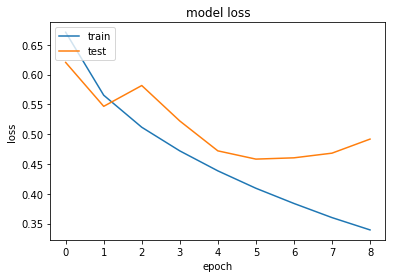

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.984425172205987
Root mean squared error:  8.59281117035633
```



### v. Model ii with dropout //MAE: 5.981143363601177, RMSE:  8.607295757527817 //Convergence until 4th epoch with .5 scaled RMSE //Somewhat worse

In [0]:
#model name:
model_name = "v"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 768)          0           concatenate[0][0]                
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      dropout[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512)          0           activation_6[0][0]               
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      dropout_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 512)          0           activation_7[0][0]               
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         dropout_2[0][0]                  
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/model_hypertuning_advanced_v.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.12.248.122:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4273206023553425208)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12385076021438912356)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11078345266942851960)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16144330192661547982)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4943037940559239881)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9038175605792892315)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 10234911853030510262)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 7946712602397252032)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 7132169946608433242)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 11884688357336035592)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 13588935507713946626)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.007795572280884 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6916 - mean_squared_error: 0.6916INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.859474182128906 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6916 - mean_squared_error: 0.6916INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.4570839405059814 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.956329584121704 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 792s 193us/sample - loss: 0.6916 - mean_squared_error: 0.6916 - val_loss: 0.7854 - val_mean_squared_error: 0.7854
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5888 - mean_squared_error: 0.5888INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 742s 181us/sample - loss: 0.5888 - mean_squared_error: 0.5888 - val_loss: 0.5954 - val_mean_squared_error: 0.5954
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5403 - mean_squared_error: 0.5403INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 741s 181us/sample - loss: 0.5403 - mean_squared_error: 0.5403 - val_loss: 0.5378 - val_mean_squared_error: 0.5378
Epoch 4/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5048 - mean_squared_error: 0.5048INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 747s 182us/sample - loss: 0.5048 - mean_squared_error: 0.5048 - val_loss: 0.5008 - val_mean_squared_error: 0.5008
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4765 - mean_squared_error: 0.4765INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 751s 183us/sample - loss: 0.4765 - mean_squared_error: 0.4765 - val_loss: 0.4916 - val_mean_squared_error: 0.4916
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4526 - mean_squared_error: 0.4526INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 751s 183us/sample - loss: 0.4526 - mean_squared_error: 0.4526 - val_loss: 0.4780 - val_mean_squared_error: 0.4780
Epoch 7/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4316 - mean_squared_error: 0.4316INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 749s 183us/sample - loss: 0.4316 - mean_squared_error: 0.4316 - val_loss: 0.4720 - val_mean_squared_error: 0.4720
Epoch 8/25
4099573/4099573 [==============================] - 741s 181us/sample - loss: 0.4130 - mean_squared_error: 0.4130 - val_loss: 0.4950 - val_mean_squared_error: 0.4950
Epoch 9/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.3964 - mean_squared_error: 0.3964INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 741s 181us/sample - loss: 0.3964 - mean_squared_error: 0.3964 - val_loss: 0.4591 - val_mean_squared_error: 0.4591
Epoch 10/25
4099573/4099573 [==============================] - 739s 180us/sample - loss: 0.3822 - mean_squared_error: 0.3822 - val_loss: 0.4839 - val_mean_squared_error: 0.4839
Epoch 11/25
4099573/4099573 [==============================] - 739s 180us/sample - loss: 0.3690 - mean_squared_error: 0.3690 - val_loss: 0.4611 - val_mean_squared_error: 0.4611
Epoch 12/25
4099573/4099573 [==============================] - 742s 181us/sample - loss: 0.3567 - mean_squared_error: 0.3567 - val_loss: 0.4713 - val_mean_squared_error: 0.4713
```



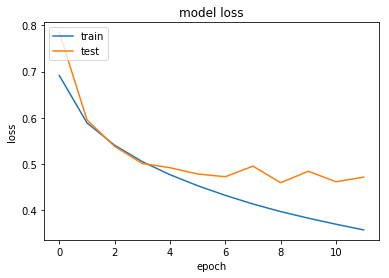

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.981143363601177
Root mean squared error:  8.607295757527817
```



### inv-i. Model ii without ResNet type structure //MAE: 5.7125793484528105, RMSE: 8.412213954703198 //Slightly worse

In [0]:
#model name:
model_name = "inv-i"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 256)          14592     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 256)          1024      
_________________________________________________________________
activation (Activation)      (None, 322, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 256)          196864    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 320, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 256)          196864    
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 318, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 256)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 512)          393728    
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 512)          2048      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 512)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 512)          786944    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 512)          2048      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 512)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 512)          786944    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 512)          2048      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 512)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 512)               2048      
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 512)               2048      
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
=================================================================
Total params: 2,915,241
Trainable params: 2,908,585
Non-trainable params: 6,656
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/model_hypertuning_advanced_inv-i.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.40.242.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3936084706406653260)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17461129747748177779)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15617923242530171571)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 583898712792705781)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 13682208288043103934)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 17725878202214302142)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 5019071750024115671)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 9000287016925008485)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 6835501005327161457)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 6263956846844538494)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 6985869051465541366)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.240433216094971 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6638 - mean_squared_error: 0.6638INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.901808977127075 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6638 - mean_squared_error: 0.6638INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.213235378265381 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.164583206176758 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 772s 188us/sample - loss: 0.6638 - mean_squared_error: 0.6638 - val_loss: 0.6535 - val_mean_squared_error: 0.6535
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5634 - mean_squared_error: 0.5634INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 721s 176us/sample - loss: 0.5634 - mean_squared_error: 0.5634 - val_loss: 0.5606 - val_mean_squared_error: 0.5606
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5105 - mean_squared_error: 0.5105INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 719s 175us/sample - loss: 0.5105 - mean_squared_error: 0.5105 - val_loss: 0.5233 - val_mean_squared_error: 0.5233
Epoch 4/25
4099573/4099573 [==============================] - 724s 177us/sample - loss: 0.4714 - mean_squared_error: 0.4714 - val_loss: 0.5364 - val_mean_squared_error: 0.5364
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4399 - mean_squared_error: 0.4399INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 722s 176us/sample - loss: 0.4399 - mean_squared_error: 0.4399 - val_loss: 0.4722 - val_mean_squared_error: 0.4722
Epoch 6/25
4099573/4099573 [==============================] - 717s 175us/sample - loss: 0.4116 - mean_squared_error: 0.4116 - val_loss: 0.4751 - val_mean_squared_error: 0.4751
Epoch 7/25
3475968/4099573 [========================>.....] - ETA: 1:41 - loss: 0.3866 - mean_squared_error: 0.3866Buffered data was truncated after reaching the output size limit.
```



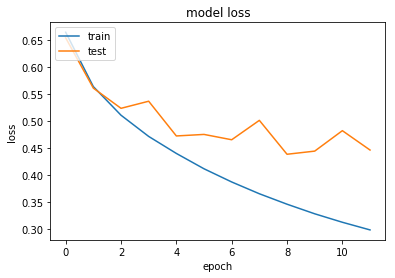

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.7125793484528105
Root mean squared error:  8.412213954703198
```



### inv-ii. Model i with 3 fully connected layers //MAE: 5.959382783272413, RMSE:  8.64378773766334 //Basically no difference

In [0]:
#model name:
model_name = "inv-ii"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalAveragePooling1D()(x_mid)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_average_pooling1d[0][0]   
                                                                 global_average_pooling1d_1[0][0] 
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         activation_7[0][0]               
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/model_hypertuning_advanced_inv-ii.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.40.242.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3936084706406653260)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17461129747748177779)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15617923242530171571)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 583898712792705781)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 13682208288043103934)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 17725878202214302142)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 5019071750024115671)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 9000287016925008485)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 6835501005327161457)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 6263956846844538494)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 6985869051465541366)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.656160354614258 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6534 - mean_squared_error: 0.6534INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.658546209335327 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6533 - mean_squared_error: 0.6534INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.5427117347717285 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.016971826553345 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 788s 192us/sample - loss: 0.6534 - mean_squared_error: 0.6534 - val_loss: 0.6351 - val_mean_squared_error: 0.6351
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5629 - mean_squared_error: 0.5629INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 736s 179us/sample - loss: 0.5629 - mean_squared_error: 0.5629 - val_loss: 0.5946 - val_mean_squared_error: 0.5946
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5114 - mean_squared_error: 0.5114INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 734s 179us/sample - loss: 0.5114 - mean_squared_error: 0.5114 - val_loss: 0.5261 - val_mean_squared_error: 0.5261
Epoch 4/25
4099573/4099573 [==============================] - 724s 177us/sample - loss: 0.4750 - mean_squared_error: 0.4750 - val_loss: 0.8022 - val_mean_squared_error: 0.8022
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4457 - mean_squared_error: 0.4457INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 738s 180us/sample - loss: 0.4457 - mean_squared_error: 0.4457 - val_loss: 0.4897 - val_mean_squared_error: 0.4897
Epoch 6/25
4099573/4099573 [==============================] - 735s 179us/sample - loss: 0.4211 - mean_squared_error: 0.4211 - val_loss: 0.5166 - val_mean_squared_error: 0.5166
Epoch 7/25
3476480/4099573 [========================>.....] - ETA: 1:41 - loss: 0.3990 - mean_squared_error: 0.3990Buffered data was truncated after reaching the output size limit.
```



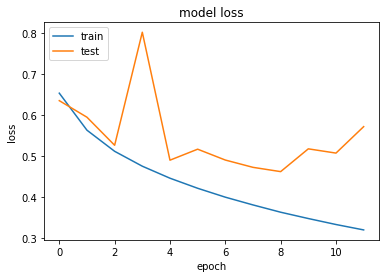

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.959382783272413
Root mean squared error:  8.64378773766334
```



### inv-iii. Model ii with 1024 batch size //MAE: 5.905647131786859,  RMSE:  8.522776741549668 //Somewhat worse

In [0]:
#model name:
model_name = "inv-iii"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 256)     196864      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 256)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 256)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 512)     393728      max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 512)     786944      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 512)     2048        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 512)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     786944      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 512)     2048        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 512)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768)          0           global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_1[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          393728      concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 512)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 512)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            513         activation_7[0][0]               
==================================================================================================
Total params: 3,046,313
Trainable params: 3,039,657
Non-trainable params: 6,656
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])



```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/model_hypertuning_advanced_inv-iii.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.0.87.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14956084448146808676)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15392830358712396317)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9513448298262753501)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 8675721626042865856)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4421722393968940682)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 7866137083438890587)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 5750650627801077184)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 8261434117700810270)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 72756640106117930)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 8010111503558770997)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 13373262413845469260)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.420286417007446 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6586 - mean_squared_error: 0.6586INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.551653623580933 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6585 - mean_squared_error: 0.6585INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.008478164672852 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.9400715827941895 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 530s 129us/sample - loss: 0.6585 - mean_squared_error: 0.6585 - val_loss: 0.7691 - val_mean_squared_error: 0.7691
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5549 - mean_squared_error: 0.5549INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 476s 116us/sample - loss: 0.5549 - mean_squared_error: 0.5549 - val_loss: 0.5636 - val_mean_squared_error: 0.5636
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5069 - mean_squared_error: 0.5069INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 470s 115us/sample - loss: 0.5069 - mean_squared_error: 0.5069 - val_loss: 0.5293 - val_mean_squared_error: 0.5293
Epoch 4/25
4099573/4099573 [==============================] - 473s 115us/sample - loss: 0.4682 - mean_squared_error: 0.4682 - val_loss: 0.5594 - val_mean_squared_error: 0.5594
Epoch 5/25
4099573/4099573 [==============================] - 485s 118us/sample - loss: 0.4345 - mean_squared_error: 0.4345 - val_loss: 0.5549 - val_mean_squared_error: 0.5549
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4050 - mean_squared_error: 0.4050INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 483s 118us/sample - loss: 0.4050 - mean_squared_error: 0.4050 - val_loss: 0.4755 - val_mean_squared_error: 0.4755
Epoch 7/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.3783 - mean_squared_error: 0.3783INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 476s 116us/sample - loss: 0.3783 - mean_squared_error: 0.3783 - val_loss: 0.4500 - val_mean_squared_error: 0.4500
Epoch 8/25
4099573/4099573 [==============================] - 472s 115us/sample - loss: 0.3542 - mean_squared_error: 0.3542 - val_loss: 0.4644 - val_mean_squared_error: 0.4644
Epoch 9/25
4099573/4099573 [==============================] - 472s 115us/sample - loss: 0.3324 - mean_squared_error: 0.3324 - val_loss: 0.4902 - val_mean_squared_error: 0.4902
Epoch 10/25
4099573/4099573 [==============================] - 468s 114us/sample - loss: 0.3132 - mean_squared_error: 0.3132 - val_loss: 0.4506 - val_mean_squared_error: 0.4506
```



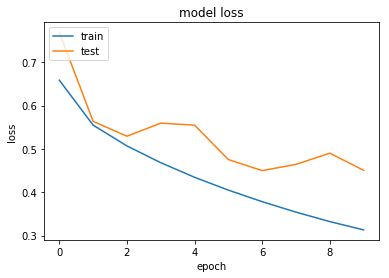

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.905647131786859
Root mean squared error:  8.522776741549668
```



### inv-iv. Model ii with 7 stride 3 filters insted of max pool //MAE: 5.903539089504189, RMSE:  8.538110091714124 //Somewhat worse

In [0]:
#model name:
model_name = "inv-iv"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv1D(512, 7, 3)(x_mid)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/model_hypertuning_advanced_inv-iv.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.0.87.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14956084448146808676)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15392830358712396317)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9513448298262753501)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 8675721626042865856)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4421722393968940682)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 7866137083438890587)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 5750650627801077184)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 8261434117700810270)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 72756640106117930)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 8010111503558770997)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 13373262413845469260)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.390992641448975 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6553 - mean_squared_error: 0.6553INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.30625581741333 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6553 - mean_squared_error: 0.6553INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.39539909362793 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.145106315612793 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 800s 195us/sample - loss: 0.6552 - mean_squared_error: 0.6552 - val_loss: 0.6449 - val_mean_squared_error: 0.6449
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5559 - mean_squared_error: 0.5559INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 744s 181us/sample - loss: 0.5559 - mean_squared_error: 0.5559 - val_loss: 0.5801 - val_mean_squared_error: 0.5801
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5052 - mean_squared_error: 0.5052INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 748s 182us/sample - loss: 0.5052 - mean_squared_error: 0.5052 - val_loss: 0.5235 - val_mean_squared_error: 0.5235
Epoch 4/25
4099573/4099573 [==============================] - 743s 181us/sample - loss: 0.4642 - mean_squared_error: 0.4642 - val_loss: 0.5582 - val_mean_squared_error: 0.5582
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4289 - mean_squared_error: 0.4289INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 742s 181us/sample - loss: 0.4289 - mean_squared_error: 0.4289 - val_loss: 0.4717 - val_mean_squared_error: 0.4717
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.3969 - mean_squared_error: 0.3969INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 744s 181us/sample - loss: 0.3969 - mean_squared_error: 0.3969 - val_loss: 0.4517 - val_mean_squared_error: 0.4517
Epoch 7/25
4099573/4099573 [==============================] - 751s 183us/sample - loss: 0.3689 - mean_squared_error: 0.3689 - val_loss: 0.5579 - val_mean_squared_error: 0.5579
Epoch 8/25
4099573/4099573 [==============================] - 749s 183us/sample - loss: 0.3437 - mean_squared_error: 0.3437 - val_loss: 0.4601 - val_mean_squared_error: 0.4601
Epoch 9/25
4099573/4099573 [==============================] - 737s 180us/sample - loss: 0.3220 - mean_squared_error: 0.3220 - val_loss: 0.4755 - val_mean_squared_error: 0.4755
```



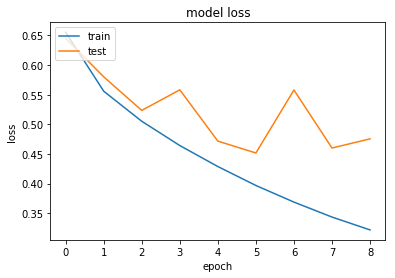

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.903539089504189
Root mean squared error:  8.538110091714124
```



### inv-v. Model ii with two 7 stride 2 filters, no max pool //MAE:  5.695605944311724, RMSE: 8.352280702594635 //Basically just as good

In [0]:
#model name:
model_name = "inv-v"
model_save_loc = model_saves_folder_location+"model_hypertuning_advanced_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv1D(512, 7, 2)(x_mid)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid_02 = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv1D(768, 7, 2)(x_mid_02)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(768, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid_02 = tf.keras.layers.GlobalMaxPooling1D()(x_mid_02)
x_mid = tf.keras.layers.GlobalMaxPooling1D()(x_mid)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x_mid_02, x], axis=-1)
x = tf.keras.layers.Dense(768)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(768)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 256)     14592       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 256)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 256)     196864      activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 256)     1024        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 157, 512)     918016      activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 157, 512)     2048        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 157, 512)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 155, 512)     786944      activation_2[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 155, 512)     2048        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 155, 512)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 75, 768)      2753280     activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 75, 768)      3072        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 75, 768)      0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 73, 768)      1770240     activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 73, 768)      3072        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 73, 768)      0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 256)          0           activation_1[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 512)          0           activation_3[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 768)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1536)         0           global_max_pooling1d_1[0][0]     
                                                                 global_max_pooling1d[0][0]       
                                                                 global_max_pooling1d_2[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (None, 768)          1180416     concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 768)          3072        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 768)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 768)          590592      activation_6[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 768)          3072        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 768)          0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            769         activation_7[0][0]               
==================================================================================================
Total params: 8,230,313
Trainable params: 8,221,097
Non-trainable params: 9,216
__________________________________________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```
Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning_Advanced/model_hypertuning_advanced_inv-v.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.114.153.146:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4903675999660932560)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12540370942450818205)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1449967844073027384)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7183808893121092396)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 1506944715668710201)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12358959664416521550)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 9552641476705194936)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5950058021354215485)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 1605384769429869382)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 1648752857301122011)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 1261639315056423630)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.996456861495972 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6578 - mean_squared_error: 0.6578INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.7206199169158936 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6578 - mean_squared_error: 0.6578INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.610627174377441 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.160784959793091 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 867s 211us/sample - loss: 0.6578 - mean_squared_error: 0.6578 - val_loss: 0.6662 - val_mean_squared_error: 0.6662
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5475 - mean_squared_error: 0.5475INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 808s 197us/sample - loss: 0.5475 - mean_squared_error: 0.5475 - val_loss: 0.5359 - val_mean_squared_error: 0.5359
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4858 - mean_squared_error: 0.4858INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 805s 196us/sample - loss: 0.4858 - mean_squared_error: 0.4858 - val_loss: 0.5055 - val_mean_squared_error: 0.5055
Epoch 4/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4339 - mean_squared_error: 0.4339INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 806s 197us/sample - loss: 0.4339 - mean_squared_error: 0.4339 - val_loss: 0.5019 - val_mean_squared_error: 0.5019
Epoch 5/25
4099573/4099573 [==============================] - 805s 196us/sample - loss: 0.3895 - mean_squared_error: 0.3895 - val_loss: 0.5316 - val_mean_squared_error: 0.5316
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.3514 - mean_squared_error: 0.3514INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 814s 199us/sample - loss: 0.3514 - mean_squared_error: 0.3514 - val_loss: 0.4455 - val_mean_squared_error: 0.4455
Epoch 7/25
3388928/4099573 [=======================>......] - ETA: 2:07 - loss: 0.3162 - mean_squared_error: 0.3162Buffered data was truncated after reaching the output size limit.
```



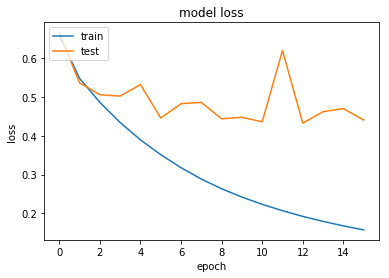

In [0]:
#history for loss
plt_history(history)

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

TPU worker setup:
INFO:tensorflow:Querying Tensorflow master (grpc://10.114.153.146:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4903675999660932560)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12540370942450818205)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1449967844073027384)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7183808893121092396)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 1506944715668710201)
INFO:tensorflow:*** Available Device:

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.695605944311724
Root mean squared error:  8.352280702594635
```



## Results



*   Maybe use train_patience=5 instead of 3, some models might not have converged
*   ResNet structure potentially irrelevant
*  Global max pool might be be significantly better than global average pool
*  Replacing max pool with convolution stride 3 is ...
*  Scaling label seems to help slightly
*  Dropout smoothes the learning, maybe a little dropout could help
*  More stages dont seem to help
*  One can replace max pool with larger kernal size and larger than 1 stride size

